In [16]:
import numpy as np
import os
import math
import seaborn as sns

In [22]:
def read_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    input_file = "".join(lines)
    return input_file

In [23]:
def get_personally_generated_sequence(filename=None):
    if filename is None:
        print("Введите путь к файлу со сгенерированной последовательностью:")
        filename = input()
    input_file = read_from_file(filename)
    input_file = input_file.split(",")
    sequence = [int(elem) for elem in input_file if len(elem) != 0]

    # нормализую
    sequence = [elem / 1023 for elem in sequence]
    return sequence

In [42]:
a = get_personally_generated_sequence("../rnd.dat")

### Математическое ожидание

In [66]:
def calculate_expected_value(seq):
    elements_count = {}
    # iterating over the elements for frequency
    for element in seq:
    # checking whether it is in the dict or not
        if element in elements_count:
            # incerementing the count by 1
            elements_count[element] += 1
        else:
            # setting the count to 1
            elements_count[element] = 1

    elements_probs = {k: v / len(seq) for k, v in elements_count.items()}
    
    values = np.array(list(elements_probs.keys()))
    weights = np.array(list(elements_probs.values()))
    return (values * weights).sum() / weights.sum()

In [69]:
expected_value = calculate_expected_value(a)

In [70]:
expected_value

0.49936119257086997

In [28]:
arr_a = np.array(a)

### Среднеквадратичное отклонение

In [71]:
def calculate_standard_deviation(seq):
    # arr_seq = np.array(seq)
    mean_seq = calculate_expected_value(seq)
    return math.sqrt(sum([(elem - mean_seq) ** 2 for elem in seq]) / len(seq))

In [72]:
calculate_standard_deviation(a)

0.28910657646971155

### Отрисовка графиков

In [73]:
def plot_mean_graph(seq, step=1):
    seq_amounts = []
    amount_to_mean = []
    for i in range(50, 0, -step):
        cur_value_amount = len(seq) // i
        seq_amounts.append(cur_value_amount)
        seq = np.array(seq)
        cur_value_mean = calculate_expected_value(seq[:cur_value_amount])
        amount_to_mean.append(cur_value_mean)
    
    sns.lineplot(seq_amounts, amount_to_mean)

In [74]:
def plot_std_graph(seq, step=1):
    seq_amounts = []
    amount_to_std = []
    for i in range(50, 0, -step):
        cur_value_amount = len(seq) // i
        seq_amounts.append(cur_value_amount)
        cur_value_std = calculate_standard_deviation(seq[:cur_value_amount])
        amount_to_std.append(cur_value_std)
    
    sns.lineplot(seq_amounts, amount_to_std)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


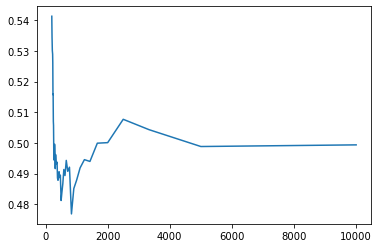

In [75]:
plot_mean_graph(a)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


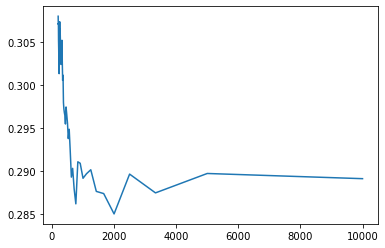

In [76]:
plot_std_graph(a)

### Относительные погрешности

Целевое мат. ожидание: $0.5$

Целевое std: $0.2887$

In [81]:
def get_relative_errors(seq):
    GOAL_MEAN = 0.5
    GOAL_STD = 0.2887
    cur_value_mean = calculate_expected_value(seq)
    cur_value_std = calculate_standard_deviation(seq)
    print("Относительная погрешность мат. ожидания: ", abs(GOAL_MEAN - cur_value_mean))
    print("Относительная погрешность среднекв. отклонения: ", abs(GOAL_STD - cur_value_std))


In [82]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.0006388074291300283
Относительная погрешность среднекв. отклонения:  0.00040657646971153927


In [90]:
import scipy

### Критерий хи-квадрат

In [152]:
def chi_square(seq, p=0.05, given_seqs_n_k=None):
    if given_seqs_n_k is not None:
        theor, emp, k = given_seqs_n_k
        chi_sq = sum([((theor[i] - emp[i]) ** 2) / theor[i] for i in range(len(theor))])
    else:
        n = len(seq)
        k = math.ceil(1 + 1.4 * math.log(n))
        intervals = list(np.linspace(0, 1, k))
        interval_pairs = []
        for i in range(len(intervals) - 1):
            interval_pairs.append((intervals[i], intervals[i + 1]))
        
        interval_cnts = {}
        for pair_a, pair_b in interval_pairs:
            cur_cnt = 0
            for elem in seq:
                if pair_a <= elem < pair_b:
                    cur_cnt += 1
            interval_cnts[f"{pair_a}-{pair_b}"] = cur_cnt
        
        est = round(n / k, 3)
        chi_sq = sum([((v - est) ** 2) / est for _, v in interval_cnts.items()])

    chi_crit = round(scipy.stats.chi2.ppf(1 - p, df=(k - 1)), 4)
    return chi_sq <= chi_crit

In [153]:
chi_square(a)

False

### Критерий серий

In [154]:
def real_seq_to_integer(seq, d):
    int_seq = [math.floor(elem * d) for elem in seq if elem < 1]
    return int_seq

In [155]:
def serial_test(seq):
    d = 8
    int_seq = real_seq_to_integer(seq, d)
    emp = [0] * d * d

    n = len(int_seq)
    half_n = n // 2
    for i in range(half_n):
        q, r = int_seq[2 * i], int_seq[2 * i + 1]
        emp[q * d + r] += 1

    theor = [n / (2 * d * d)] * d * d

    return chi_square(None, given_seqs_n_k=(theor, emp, d * d))


In [156]:
serial_test(a)

False